# Import Relevant Credentials and Packages

In [1]:
from config import database,user,password,server
from joblib import dump,load
import pymssql
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

# Connect to SQL Server to make the data

In [2]:
conn = pymssql.connect(server,user,password,database)
query1 = "SELECT BusinessID,Stars FROM dbo.Business"
df1 = pd.read_sql(query1,conn)

d:\Python\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [3]:
query2 = "SELECT * FROM dbo.MachineLearning"
df2 = pd.read_sql(query2,conn)

d:\Python\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
df = df1.merge(df2,on='BusinessID',how='inner')
df = df.drop_duplicates()
df.drop('BusinessID',inplace=True,axis=1)

# Convert Categorical Variables into Numeric

In [5]:
replace = list(df['Alcohol'].unique())
replace

['none', None, 'beer_and_wine', 'full_bar']

In [6]:
df.replace(replace,['0',np.nan,'1','2'],inplace=True)

In [7]:
replace = list(df['NoiseLevel'].unique())
replace.remove(np.nan)
replace

['average', 'quiet', 'loud', 'very_loud']

In [8]:
df.replace(replace,['1','0','2','3'],inplace=True)

In [9]:
replace = list(df['RestaurantsAttire'].unique())
replace.remove(np.nan)
replace

['casual', 'dressy', 'formal']

In [10]:
df.replace(replace,['0','1','2'],inplace=True)

In [11]:
replace = list(df['WiFi'].unique())
replace.remove(np.nan)
replace

['no', 'free', 'paid']

In [12]:
df.replace(replace,['0','2','1'],inplace=True)

In [13]:
for i in df.columns:
    df[i] = pd.to_numeric(df[i])

# Machine Learning Process

In [14]:
# Split the dependent and independent variables
X = df.copy()
X.drop('Stars',axis=1,inplace=True)
y = df['Stars'].copy()

In [15]:
# Standardize th independent variables (model tuning)
sc = StandardScaler()
X_trans = pd.DataFrame(sc.fit_transform(X),index=X.index,columns=X.columns)

In [16]:
# Split the test dataset and the train dataset
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size = 0.25,random_state = 61)

# Use Grid Search for Parameter Tuning

In [17]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [18]:
estimator = xgb.XGBClassifier(
    objective = 'multi:softmax',
    num_class = 9,
    nthread=4,
    seed =61,
    missing = np.nan
)

parameters = {
    'max_depth': [3,5],
    'n_estimators': [100,140,180],
    'learning_rate': [0.1, 0.3, 0.05],
    'min_child_weight':[1,3]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring='f1_micro',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

In [19]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=-1, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_class=9, num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.3, 0.05], 'max_depth': [3, 5],
                         'min_child_weight': [1, 3],
                         'n_estimators': [100, 140, 180]},
             scoring='f1_micro', verbose=True)

In [20]:
print(grid_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=-1, monotone_constraints='()', n_estimators=140, n_jobs=4,
              nthread=4, num_class=9, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', ...)


# Write the optimal model

In [33]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', 
              learning_rate=0.1, max_depth=5, min_child_weight=1,
              missing=np.nan, n_estimators=140,
              n_jobs=4, nthread=4, num_class=9,
              objective='multi:softmax', predictor='auto')

In [34]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=140,
              n_jobs=4, nthread=4, num_class=9, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', ...)

In [35]:
y_predicted = clf.predict(X_test)

In [40]:
print(matthews_corrcoef(y_test,y_predicted))

0.15877073493808488


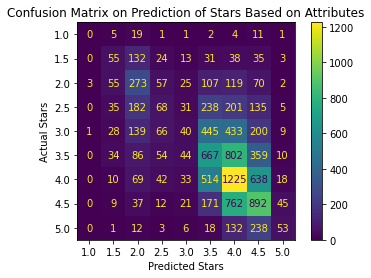

In [50]:
labels = [1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
ticks = [0,1,2,3,4,5,6,7,8]
cm = confusion_matrix(y_test,y_predicted)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.xlabel('Predicted Stars')
plt.ylabel('Actual Stars')
plt.xticks(ticks,labels)
plt.yticks(ticks,labels)
plt.title('Confusion Matrix on Prediction of Stars Based on Attributes')
plt.show()

# Export the optimal model

In [37]:
dump(clf,'Capstone_MachineLearning.model')

['Capstone_MachineLearning.model']